In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from treeffuser import Treeffuser
import statsmodels.formula.api as smf
from sklearn.metrics import RocCurveDisplay

from data import load_amp, load_uke, GENERATIVE_COLUMNS

X_amp, covariates_amp = load_amp(
    "../data/updrs_amp_all.csv", sample_one_measurement_per_subject=True
)
X_amp[GENERATIVE_COLUMNS]

,UPDRS I,UPDRS II,UPDRS III,UPDRS IV,PDQ,MoCA
0,17.307692,21.153846,11.363636,37.500000,NaN,96.666667
1,15.384615,21.153846,9.090909,16.666667,NaN,100.000000
2,19.230769,21.153846,25.000000,25.000000,NaN,93.333333
3,17.307692,26.923077,22.727273,0.000000,NaN,83.333333
4,NaN,NaN,17.424242,33.333333,NaN,NaN
...,...,...,...,...,...,...
3147,15.384615,11.538462,11.363636,4.166667,0.781250,93.333333
3148,19.230769,28.846154,21.212121,0.000000,17.031250,96.666667
3149,19.230769,9.615385,7.575758,0.000000,9.843750,90.000000
3150,5.769231,9.615385,16.666667,0.000000,1.041667,100.000000


In [2]:
x_uke, covariates_uke, extra_data_uke, y_uke = load_uke("../data/pdq_uke_new.csv")

valid_measurements = (~pd.isna(x_uke["PDQ"])) & (~pd.isna(y_uke["PDQ"]))
x_uke = x_uke[valid_measurements]
covariates_uke = covariates_uke[valid_measurements]
extra_data_uke = extra_data_uke[valid_measurements]
y_uke = y_uke[valid_measurements]

x_uke

,UPDRS I,UPDRS II,UPDRS III,UPDRS IV,PDQ,MoCA
0,7.692308,21.153846,18.181818,41.666667,12.656250,NaN
1,13.461538,19.230769,32.575758,0.000000,5.468750,96.666667
2,17.307692,25.000000,19.696970,16.666667,28.906250,80.000000
4,5.769231,38.461538,22.727273,58.333333,16.562500,90.000000
5,13.461538,28.846154,27.272727,41.666667,30.416667,93.333333
6,26.923077,55.769231,28.787879,45.833333,50.052083,100.000000
7,13.461538,3.846154,22.727273,45.833333,14.114583,90.000000
8,15.384615,25.000000,14.393939,45.833333,28.854167,86.666667
9,17.307692,25.000000,34.090909,NaN,11.041667,90.000000
10,26.923077,28.846154,18.939394,41.666667,35.781250,100.000000


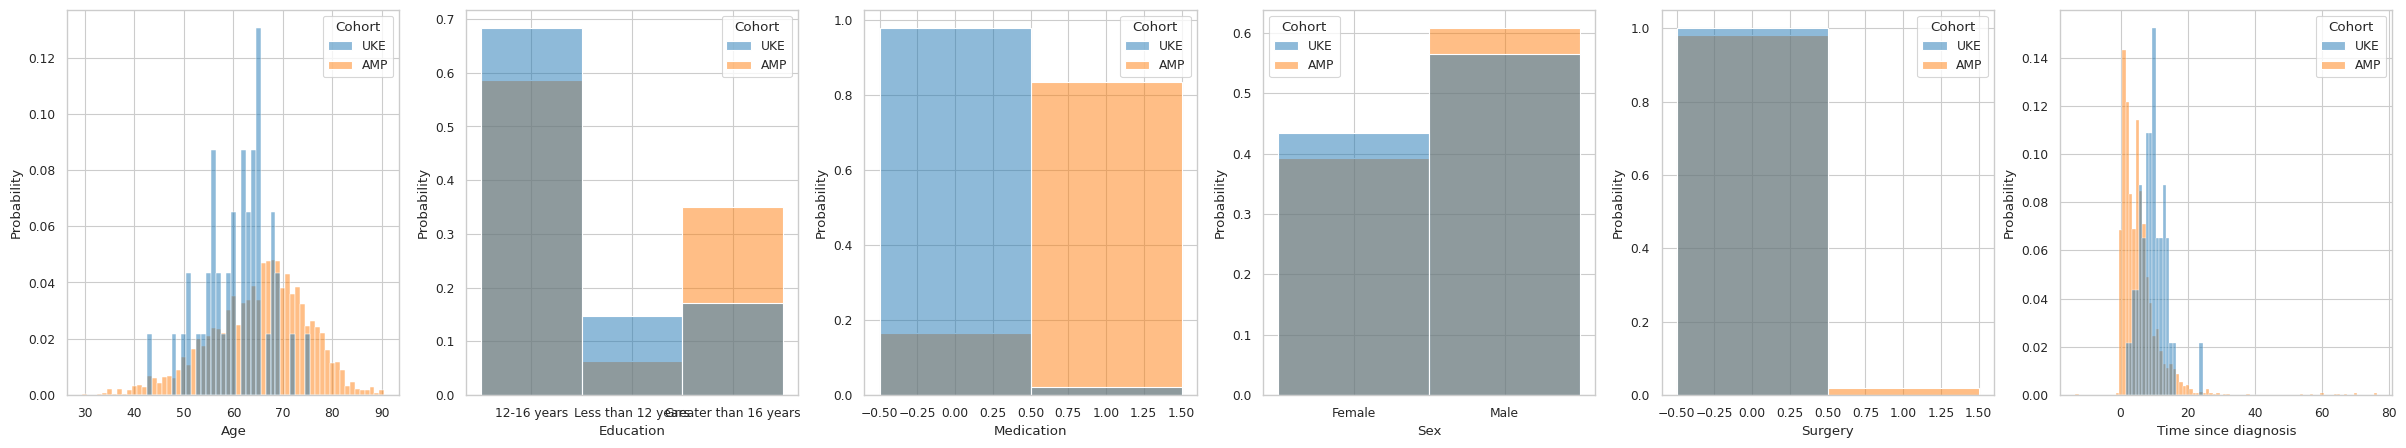

In [3]:
agg_covariates = pd.concat(
    (
        covariates_uke.reset_index(names="Subject")
        .melt(id_vars="Subject", var_name="Covariate", value_name="Value")
        .assign(Cohort="UKE"),
        covariates_amp.reset_index(names="Subject")
        .melt(id_vars="Subject", var_name="Covariate", value_name="Value")
        .assign(Cohort="AMP"),
    ),
    ignore_index=True,
)

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    covariates = agg_covariates.groupby("Covariate")
    fig, axes = plt.subplots(1, len(covariates), figsize=(5 * len(covariates), 5))
    for (covariate, covariate_data), ax in zip(covariates, axes):
        sns.histplot(
            covariate_data,
            x="Value",
            hue="Cohort",
            discrete=True,
            stat="probability",
            common_norm=False,
            ax=ax,
        )
        ax.set_xlabel(covariate)

## Train the model

In [4]:
def preprocess_covariates(covariates):
    covariates = covariates.copy()
    covariates["Sex"] = covariates["Sex"].map({"Male": 0.0, "Female": 1.0})
    covariates["Education"] = (
        covariates["Education"].cat.codes.astype(float).replace(-1, np.nan)
    )
    return covariates.astype(float)


covariates_uke = preprocess_covariates(covariates_uke)
covariates_amp = preprocess_covariates(covariates_amp)

In [5]:
model = Treeffuser(seed=42)
model.fit(
    covariates_amp.to_numpy().astype(np.float32),
    X_amp[GENERATIVE_COLUMNS].to_numpy().astype(np.float32),
)

Treeffuser(extra_lightgbm_params={}, seed=42)

In [6]:
def generate_samples(
    model, x, x_covariates, n_samples: int = 50, seed: int = 42
) -> pd.DataFrame:
    generated_samples = []
    prediction = np.clip(
        model.sample(x_covariates, n_samples=n_samples, seed=seed), 0, 100
    )

    for i, (subject_id, ground_truth) in enumerate(x.iterrows()):
        for i_key, (key, value) in enumerate(ground_truth.items()):
            if pd.isna(value):
                continue

            generated_samples.append(
                pd.DataFrame.from_dict(
                    {
                        "Prediction": prediction[:, i, i_key],
                        "Ground truth": value,
                        "Score": key,
                        "Subject": subject_id,
                        "Sample ID": np.arange(n_samples),
                    }
                )
            )

    return pd.concat(generated_samples, ignore_index=True)


uke_samples = generate_samples(
    model,
    x_uke[GENERATIVE_COLUMNS],
    covariates_uke.to_numpy().astype(np.float32),
    n_samples=500,
)

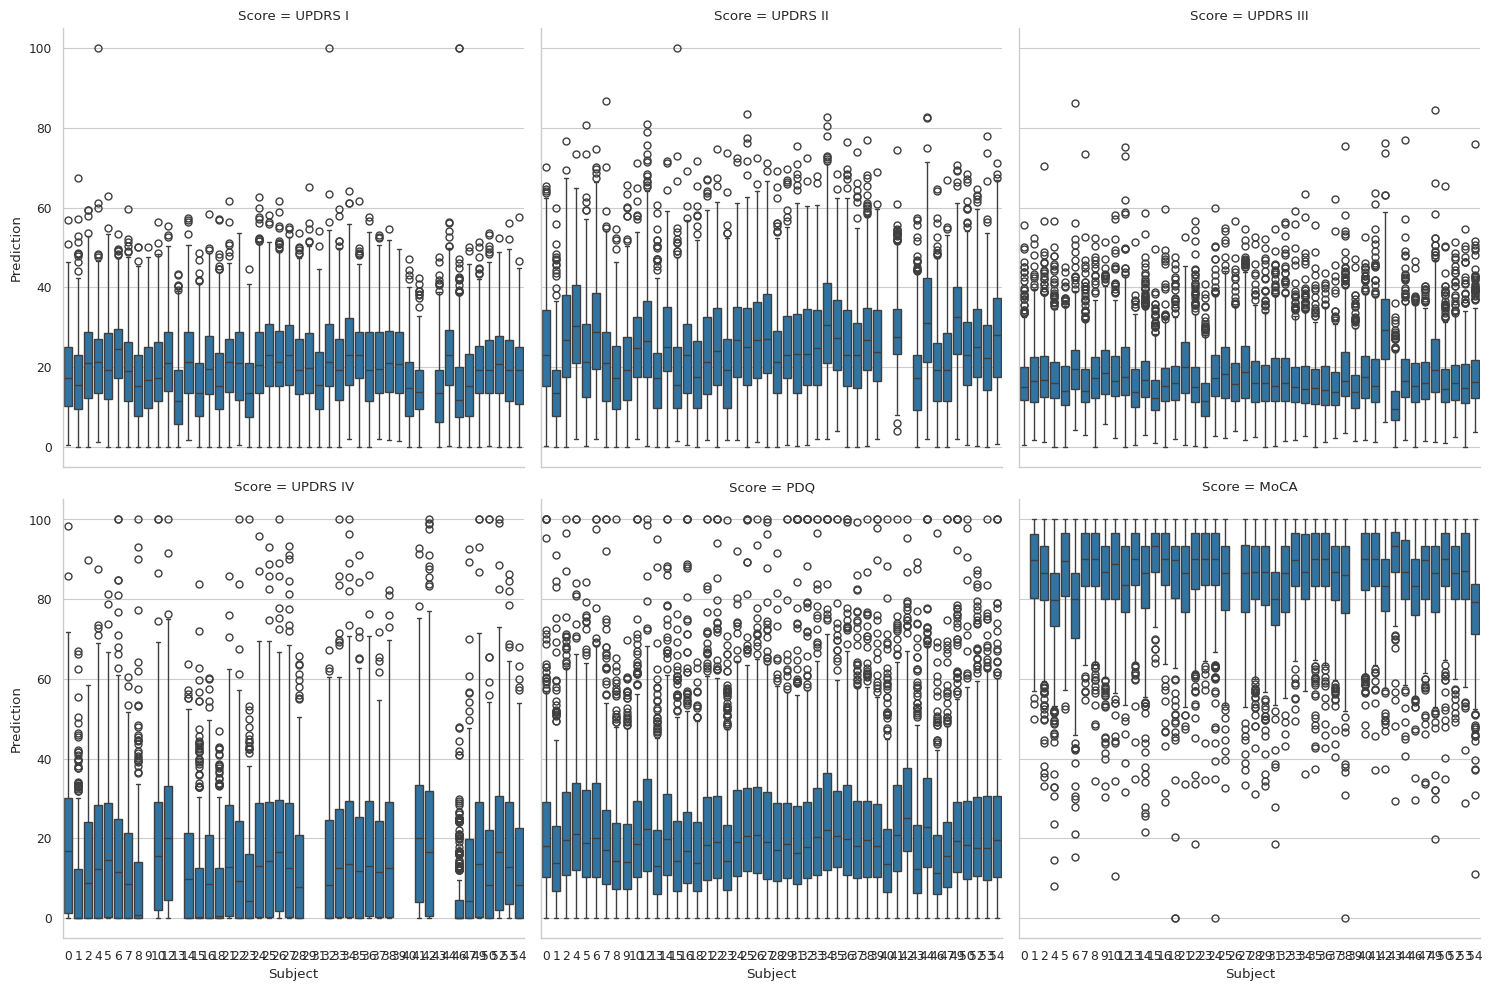

In [7]:
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.catplot(
        data=uke_samples,
        x="Subject",
        y="Prediction",
        col="Score",
        col_wrap=3,
        kind="box",
    )

22.07701771895107
18.150810102157863


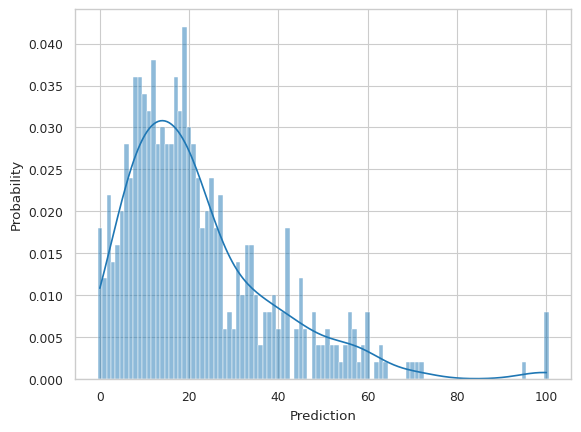

In [8]:
selection = uke_samples[
    (uke_samples["Score"] == "PDQ") & (uke_samples["Subject"] == 0)
]

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.histplot(
        selection,
        x="Prediction",
        binwidth=1,
        kde=True,
        discrete=True,
        stat="probability",
    )

print(selection["Prediction"].mean())
print(selection["Prediction"].median())

In [9]:
def calculate_representations(samples: pd.DataFrame):
    representations = []
    for subject, data in samples.groupby("Subject"):
        for score, score_data in data.groupby("Score"):
            ground_truth = score_data["Ground truth"].iloc[0]
            ground_truth_score = round(
                (score_data["Prediction"] < ground_truth).sum() / len(score_data), 2
            )
            representations.append((subject, score, ground_truth_score))

    return (
        pd.DataFrame.from_records(
            representations, columns=["Subject", "Score", "Quantity"]
        )
        .pivot(index="Subject", columns="Score", values="Quantity")
        .reset_index()
        .set_index("Subject")
    )


representations = calculate_representations(uke_samples)
representations

Score,MoCA,PDQ,UPDRS I,UPDRS II,UPDRS III,UPDRS IV
Subject,,,,,,
0,NaN,0.33,0.15,0.44,0.68,0.89
1,0.81,0.19,0.41,0.73,0.93,0.00
2,0.29,0.71,0.37,0.46,0.65,0.64
4,0.86,0.37,0.03,0.71,0.79,0.98
5,0.67,0.73,0.28,0.71,0.89,0.92
6,0.98,0.92,0.60,0.96,0.86,0.95
7,0.45,0.42,0.31,0.06,0.87,0.99
8,0.38,0.82,0.52,0.72,0.37,0.98
9,0.63,0.41,0.53,0.65,0.94,NaN


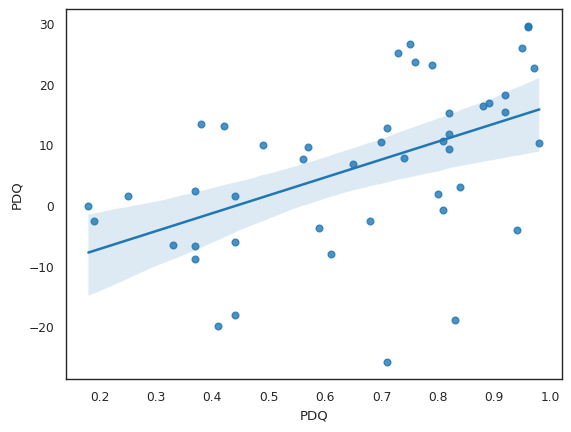

In [10]:
with sns.axes_style("white"):
    sns.set_context("paper")
    sns.regplot(x=representations["PDQ"], y=x_uke["PDQ"] - y_uke["PDQ"], robust=False)

## Predict the effect

In [11]:
data = pd.DataFrame.from_dict(
    {
        "pre_pdq": x_uke["PDQ"],
        "pre_pdq_relative": representations["PDQ"].round(1),
        "updrs_iii_change": extra_data_uke["UPDRS III: Change"],
        "diagnosis_time": covariates_uke["Time since diagnosis"],
        "improvement": ((x_uke["PDQ"] - y_uke["PDQ"]) > 10.9).astype(float),
    }
)

baseline = smf.logit(
    "improvement ~ pre_pdq + updrs_iii_change + diagnosis_time", data=data
).fit()
proposed = smf.logit("improvement ~ pre_pdq_relative", data=data).fit()

Optimization terminated successfully.
         Current function value: 0.514690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520244
         Iterations 6


7.146335207100378


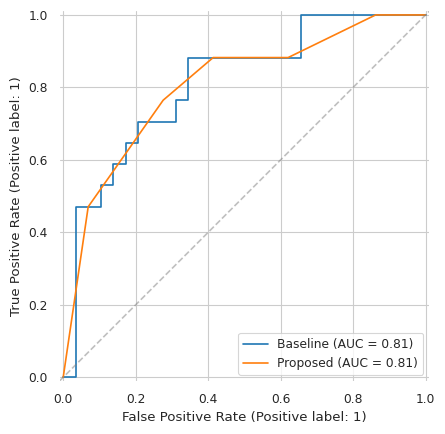

In [12]:
print(baseline.bic - proposed.bic)

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    viz = RocCurveDisplay.from_predictions(
        data["improvement"],
        baseline.predict(data),
        name="Baseline",
    )

    viz = RocCurveDisplay.from_predictions(
        data["improvement"],
        proposed.predict(data),
        name="Proposed",
        ax=viz.ax_,
    )

    viz.ax_.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        color="gray",
        transform=viz.ax_.transAxes,
        alpha=0.5,
    )
    sns.despine(bottom=True, left=True)

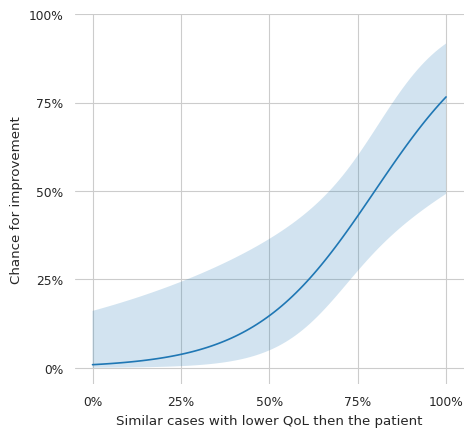

In [13]:
relative_scores = np.linspace(0, 1, 100)
predictions = (
    proposed.get_prediction(
        pd.DataFrame.from_dict({"pre_pdq_relative": relative_scores})
    )
    .summary_frame(alpha=0.05)
    .rename(columns={"predicted": "Chance for improvement"})
) * 100
predictions["Relative PDQ"] = relative_scores * 100

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    ax = sns.lineplot(data=predictions, x="Relative PDQ", y="Chance for improvement")
    ax.fill_between(
        predictions["Relative PDQ"],
        predictions["ci_lower"],
        predictions["ci_upper"],
        alpha=0.2,
    )
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])
    ax.set_xlabel("Similar cases with lower QoL then the patient")
    ax.set_aspect("equal")
    sns.despine(left=True, bottom=True)
